# EDA

## Intro

In [1]:
%reload_ext autoreload
%autoreload 1
import joblib
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import auxiliary.lists as aux_lists
import auxiliary.transformers as tr
import auxiliary.eda_functions as eda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Markdown,display
import matplotlib.ticker as ticker
%aimport auxiliary.lists
%aimport auxiliary.transformers
%aimport auxiliary.eda_functions


In [2]:
sns.set()
BASE_FIG_SIZE=(8.5,4.5)

In [3]:
# applicattion_test=pl.read_csv('data/application_test.csv')
application_train=pl.read_csv('data/application_train.csv')
bureau_balance=pl.read_csv('data/bureau_balance.csv')
bureau=pl.read_csv('data/bureau.csv')
installments_payments=pl.read_csv('data/installments_payments.csv')
POS_CASH_balance=pl.read_csv('data/POS_CASH_balance.csv')
previous_application=pl.read_csv('data/previous_application.csv')
credit_card_balance=pl.read_csv('data/credit_card_balance.csv')
id_and_target=["SK_ID_CURR", "TARGET"]

## Data Integrity

In [4]:
application_train.head()

SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,…,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
i64,i64,str,str,str,str,i64,f64,f64,f64,f64,str,str,str,str,str,f64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,str,f64,i64,i64,str,i64,i64,i64,i64,…,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64
100002,1,"""Cash loans""","""M""","""N""","""Y""",0,202500.0,406597.5,24700.5,351000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Single / not m…","""House / apartm…",0.018801,-9461,-637,-3648.0,-2120,null,1,1,0,1,1,0,"""Laborers""",1.0,2,2,"""WEDNESDAY""",10,0,0,0,…,0.0,"""reg oper accou…","""block of flats…",0.0149,"""Stone, brick""","""No""",2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,"""Cash loans""","""F""","""N""","""N""",0,270000.0,1293502.5,35698.5,1.1295e6,"""Family""","""State servant""","""Higher educati…","""Married""","""House / apartm…",0.003541,-16765,-1188,-1186.0,-291,null,1,1,0,1,1,0,"""Core staff""",2.0,1,1,"""MONDAY""",11,0,0,0,…,0.01,"""reg oper accou…","""block of flats…",0.0714,"""Block""","""No""",1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,"""Revolving loan…","""M""","""Y""","""Y""",0,67500.0,135000.0,6750.0,135000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Single / not m…","""House / apartm…",0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,"""Laborers""",1.0,2,2,"""MONDAY""",9,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,"""Cash loans""","""F""","""N""","""Y""",0,135000.0,312682.5,29686.5,297000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Civil marriage…","""House / apartm…",0.008019,-19005,-3039,-9833.0,-2437,null,1,1,0,1,0,0,"""Laborers""",2.0,2,2,"""WEDNESDAY""",17,0,0,0,…,null,null,null,null,null,null,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null
100007,0,"""Cash loans""","""M""","""N""","""Y""",0,121500.0,513000.0,21865.5,513000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Single / not m…","""House / apartm…",0.028663,-19932,-3038,-4311.0,-3458,null,1,1,0,1,0,0,"""Core staff""",1.0,2,2,"""THURSDAY""",11,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Duplicates

In [5]:
application_train['SK_ID_CURR'].is_duplicated().any()

False

#### Missing Values


**Missing value graphical overview:**

/tmp/ipykernel_10486/3508978491.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


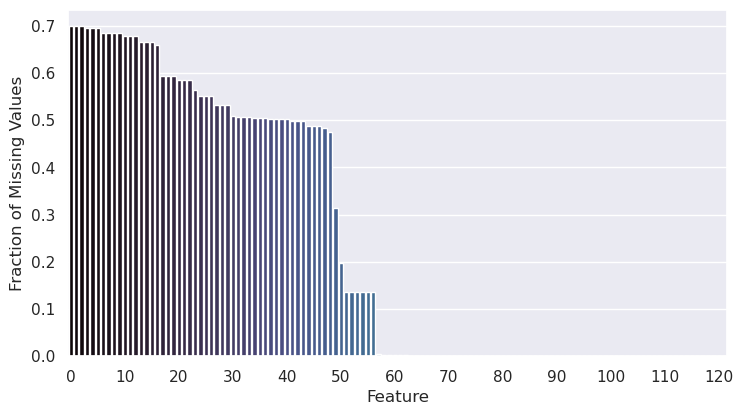

In [6]:
missing_values_main = pl.DataFrame(
    {
        "missing_fraction": application_train.null_count().transpose().to_series()
        / len(application_train),
        "feature": application_train.columns,
    }
).sort("missing_fraction", descending=True)

fig_main_missing, ax_main_missing = plt.subplots(figsize=BASE_FIG_SIZE)
sns.barplot(
    x=missing_values_main["feature"].to_numpy(),
    y=missing_values_main["missing_fraction"].to_numpy(),
    ax=ax_main_missing,
    palette=sns.color_palette('mako',n_colors=len(missing_values_main))
)
ax_main_missing.set_xticks(np.arange(len(missing_values_main), step=10))
ax_main_missing.set_xticklabels(np.arange(len(missing_values_main), step=10))
ax_main_missing.set_xlabel("Feature")
ax_main_missing.set_ylabel("Fraction of Missing Values")
plt.show()

**Features with most missing values:**

In [7]:
missing_values_main[:10]

missing_fraction,feature
f64,str
0.698723,"""COMMONAREA_AVG…"
0.698723,"""COMMONAREA_MOD…"
0.698723,"""COMMONAREA_MED…"
0.69433,"""NONLIVINGAPART…"
0.69433,"""NONLIVINGAPART…"
0.69433,"""NONLIVINGAPART…"
0.683862,"""FONDKAPREMONT_…"
0.68355,"""LIVINGAPARTMEN…"
0.68355,"""LIVINGAPARTMEN…"


#### References in other tables:

**Percentage of users with reference in other tables:**

In [8]:
tables_with_reference = {
    "Bureau": bureau,
    "Positive Cash Balance": POS_CASH_balance,
    "Credit Card Balance": credit_card_balance,
    "Previous Application": previous_application,
    "Installments Payments": installments_payments,
}

for name, table in tables_with_reference.items():
    frac_with_reference = len(
        application_train.filter(pl.col("SK_ID_CURR").is_in(table["SK_ID_CURR"]))
    ) / len(application_train)
    display(
        Markdown(
            f"{round(frac_with_reference*100)}% of users have reference in {name} table."
        )
    )

86% of users have reference in Bureau table.

94% of users have reference in Positive Cash Balance table.

28% of users have reference in Credit Card Balance table.

95% of users have reference in Previous Application table.

95% of users have reference in Installments Payments table.

**Number of references per user:**

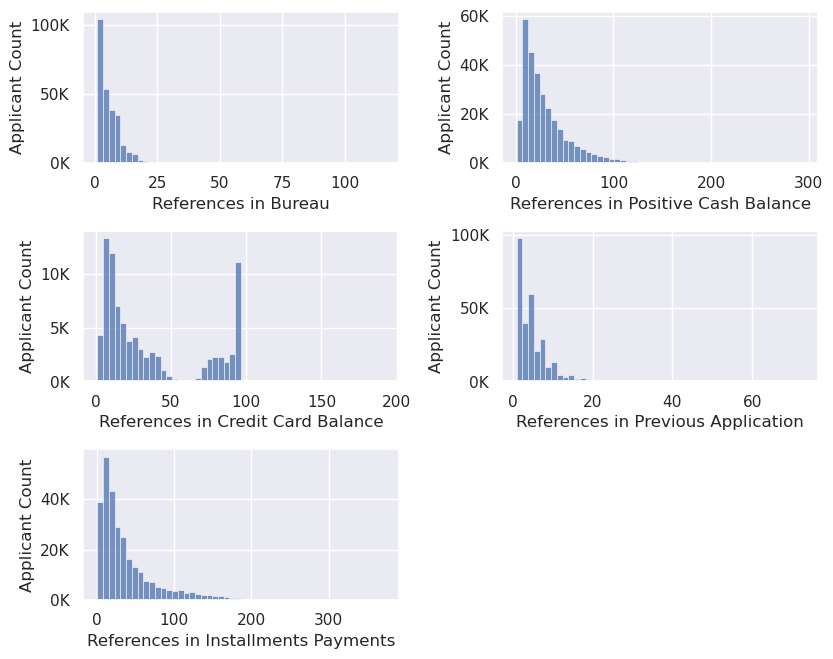

In [9]:
fig_reference_counts, ax_reference_counts = plt.subplots(
    3, 2, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 1.5)
)
ax_reference_counts = ax_reference_counts.flatten()

for i, (name, table) in enumerate(tables_with_reference.items()):
    count_table = table.filter(
        pl.col("SK_ID_CURR").is_in(application_train["SK_ID_CURR"])
    )["SK_ID_CURR"].value_counts()

    sns.histplot(count_table["counts"], ax=ax_reference_counts[i],bins=50)
    # ax_reference_counts[i].set_title(name)
    ax_reference_counts[i].set_xlabel(f"References in {name}")
    ax_reference_counts[i].set_ylabel('Applicant Count')
    ax_reference_counts[i].yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,g}".format(x / 1000) + "K")
    )
plt.delaxes(ax_reference_counts[-1])
plt.tight_layout()
plt.show()

### Cats

In [10]:
application_cat_cols=application_train.select(pl.col(pl.Utf8)).columns

NAME_FAMILY_STATUS,TARGET,count,frac
str,i64,u32,f64
"""Single / not m…",4457,45444,9.807675
"""Unknown""",0,2,0.0
"""Civil marriage…",2961,29775,9.944584
"""Separated""",1620,19770,8.194234
"""Married""",14850,196432,7.559868
"""Widow""",937,16088,5.824217


/tmp/ipykernel_10486/1744183431.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


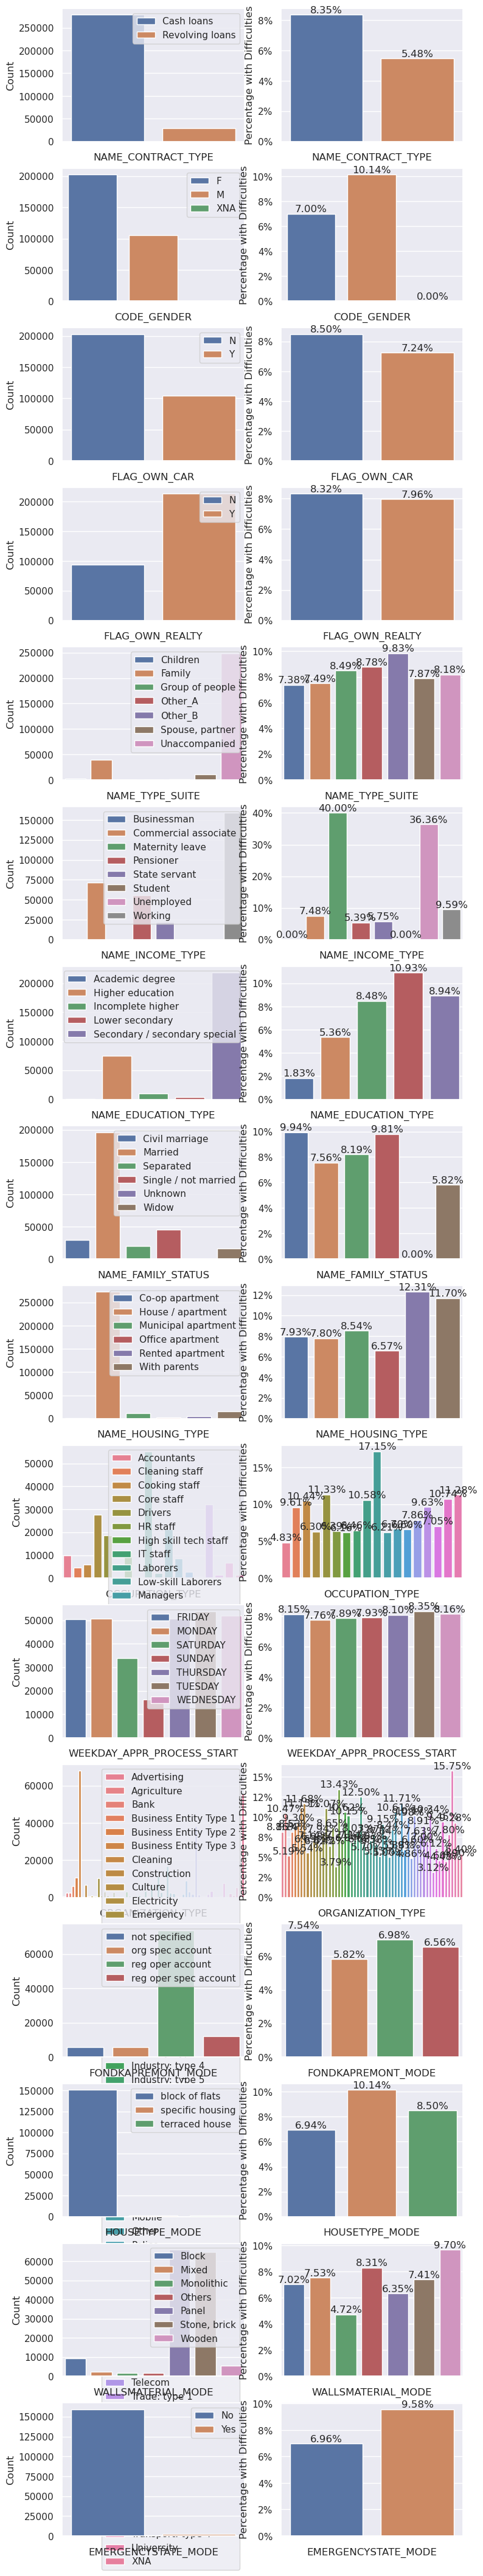

In [58]:
fig_main_cats, ax_main_cats = plt.subplots(
    16, 2, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 12)
)
for i, col in enumerate(application_cat_cols):
    sns.countplot(
        x=application_train.sort(col)[col].to_numpy(),
        hue=application_train.sort(col)[col].to_numpy(),
        ax=ax_main_cats[i, 0],
        legend=True,
    )
    agg_df = (
        application_train[[col, "TARGET"]]
        .group_by(col)
        .agg(pl.col("TARGET").sum().alias("TARGET"), pl.all().count().alias("count"))
        .with_columns((pl.col("TARGET") / pl.col("count")).alias("frac") * 100)
    ).sort(col)

    sns.barplot(
        x=agg_df.sort(col)[col].to_numpy(),
        y=agg_df.sort(col)["frac"].to_numpy(),
        hue=agg_df[col].to_numpy(),
        ax=ax_main_cats[i, 1],
        legend=False,
    )

    ax_main_cats[i, 0].set_xticklabels([])
    ax_main_cats[i, 1].set_xticklabels([])
    ax_main_cats[i, 0].set_xlabel(col)
    ax_main_cats[i, 1].set_xlabel(col)
    for container in ax_main_cats[i, 1].containers:
        ax_main_cats[i, 1].bar_label(container, fmt="%.2f%%", label_type="edge")
    sns.move_legend(ax_main_cats[i, 0], "upper right")
    ax_main_cats[i, 1].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax_main_cats[i, 0].set_ylabel("Count")
    ax_main_cats[i, 1].set_ylabel("Percentage with Difficulties")
plt.tight_layout()
plt.show()

In [45]:
agg_df

NAME_FAMILY_STATUS,TARGET
str,f64
"""Married""",4.829096
"""Widow""",0.304705
"""Single / not m…",1.449379
"""Unknown""",0.0
"""Civil marriage…",0.962892
"""Separated""",0.52681


### Feature importance

In [21]:
initial_test=eda.test_with_catboost(application_train,application_val,string_cols)
print(initial_test['report'])
print(initial_test['roc_auc'])
display(initial_test['features'][:10])

              precision    recall  f1-score   support

           0       0.96      0.73      0.83    189400
           1       0.17      0.64      0.27     16633

    accuracy                           0.72    206033
   macro avg       0.57      0.69      0.55    206033
weighted avg       0.90      0.72      0.78    206033



feature,importance
str,f64
"""EXT_SOURCE_3""",12.654869
"""EXT_SOURCE_2""",9.24611
"""EXT_SOURCE_1""",5.942974
"""AMT_CREDIT""",5.273107
"""AMT_GOODS_PRIC…",5.002266
"""AMT_ANNUITY""",4.473649
"""DAYS_BIRTH""",4.395158
"""DAYS_EMPLOYED""",3.758365
"""DAYS_ID_PUBLIS…",2.751794


### Common Sense Removal

In [9]:
application_edited_train = application_train.clone()
application_edited_val = application_val.clone()
cols_to_remove=[]

#### Home Feature Elimination

In [10]:
home_base_features = list(set([col.rsplit("_", 1)[0] for col in aux_lists.home_cols]))
best_home_features = []

for feature in home_base_features:
    best_home_features.append(
        initial_test["features"]
        .filter(pl.col("feature").str.starts_with(feature))
        .sort("importance")["feature"][0]
    )

cols_to_remove.extend([col for col in aux_lists.home_cols if col not in best_home_features])

### Col cats

In [11]:
application_train.filter(pl.col('FLAG_OWN_CAR')=="Y")['OWN_CAR_AGE'].null_count()

3

In [12]:
cols_to_remove.append('FLAG_OWN_CAR')

In [13]:
application_edited_train = application_edited_train.drop(cols_to_remove)

application_edited_val = application_edited_val.drop(cols_to_remove)

string_cols_reduced = application_edited_train.select(pl.col(pl.Utf8)).columns

test_home_removal = eda.test_with_catboost(
    application_edited_train, application_edited_val, string_cols_reduced
)

print(test_home_removal["report"])

              precision    recall  f1-score   support

           0       0.96      0.73      0.83    189400
           1       0.17      0.65      0.27     16633

    accuracy                           0.72    206033
   macro avg       0.57      0.69      0.55    206033
weighted avg       0.90      0.72      0.79    206033



### Variance

In [14]:
home_target_encoders = {}
application_edited_encoded=application_edited_train.clone()
for col in string_cols_reduced:
    home_target_encoders[col] = tr.TargetMeanOrderedLabeler(how="label")
    application_edited_encoded = application_edited_encoded.with_columns(
        home_target_encoders[col]
        .fit_transform(
            application_edited_encoded[col], application_edited_encoded["TARGET"]
        )
        .alias(col)
    )

In [15]:
feature_variance = pl.DataFrame(
    {
        "feature": application_edited_encoded.columns,
        "variance": np.var(MinMaxScaler().fit_transform(application_edited_encoded),axis=0),
    }
)
feature_variance.sort('variance')[:20]

feature,variance
str,f64
"""FLAG_MOBIL""",0.00001
"""FLAG_DOCUMENT_…",0.00001
"""FLAG_DOCUMENT_…",0.00001
"""FLAG_DOCUMENT_…",0.000039
"""FLAG_DOCUMENT_…",0.000108
"""FLAG_DOCUMENT_…",0.000177
"""AMT_INCOME_TOT…",0.00022
"""FLAG_DOCUMENT_…",0.000276
"""FLAG_DOCUMENT_…",0.000384


In [16]:
low_var_fatures=[]
for feature in feature_variance.filter(pl.col('variance')<0.001)['feature']:
    if application_edited_train[feature].n_unique()<10:
        low_var_fatures.append(feature)
        minority_count=application_edited_train[feature].value_counts().sort('counts')['counts'][0]
        print(f'{feature}: minority class count = {minority_count} feature will be removed')

FLAG_MOBIL: minority class count = 1 feature will be removed
FLAG_DOCUMENT_2: minority class count = 4 feature will be removed
FLAG_DOCUMENT_4: minority class count = 11 feature will be removed
FLAG_DOCUMENT_7: minority class count = 18 feature will be removed
FLAG_DOCUMENT_10: minority class count = 1 feature will be removed
FLAG_DOCUMENT_12: minority class count = 1 feature will be removed
FLAG_DOCUMENT_17: minority class count = 28 feature will be removed
FLAG_DOCUMENT_19: minority class count = 62 feature will be removed
FLAG_DOCUMENT_20: minority class count = 52 feature will be removed
FLAG_DOCUMENT_21: minority class count = 39 feature will be removed


In [17]:
application_edited_train=application_edited_train.drop(columns=low_var_fatures)
application_edited_val=application_edited_val.drop(columns=low_var_fatures)

In [23]:
test_var_removal = eda.test_with_catboost(
    application_edited_train, application_edited_val, string_cols_reduced
)

print(test_var_removal["report"])
print(test_var_removal["roc_auc"])

              precision    recall  f1-score   support

           0       0.96      0.73      0.83    189400
           1       0.17      0.64      0.27     16633

    accuracy                           0.72    206033
   macro avg       0.57      0.69      0.55    206033
weighted avg       0.90      0.72      0.78    206033



0.755768296203315
